# Transfer learning with a pretrained ConvNet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial you will learn how to classify cats vs dogs images by using transfer learning from a pre-trained network.


A **pre-trained model** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as it is, or use **transfer learning** to customize this model to a given task.

The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for our dataset.

  You do not need to (re)train the entire model.  The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained.

2. **Fine-Tuning**: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
2. Build an input pipeline, in this case using Keras `ImageDataGenerator`
3. Compose our model
  * Load in our pretrained base model (and pretrained weights)
  * Stack our classification layers on top
4. Train our model
5. Evaluate model


In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import IPython.display as display

from PIL import Image


In [9]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

#try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
#except Exception:
#  pass

keras = tf.keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.preprocessing import image

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.1.0-dev20191111
Eager execution: True


## Data preprocessing

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [10]:
import pathlib
#data_dir = tf.keras.utils.get_file(origin='SESSION1_ROI',fname='SESSION1_ROI')
#data_dir = pathlib.Path(data_dir)
#data_dir = pathlib.Path('/home/xingbo/Desktop/fish_identification/data/SESSION_TENT/SESSION1')
#data_dir ='/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1'

data_dir = pathlib.Path('/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1')
data_dir_test = pathlib.Path('/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1')
#data_dir = pathlib.Path('/home/xingbo/Desktop/fish_identification/SESSION1_ROI/')
data_dir

PosixPath('/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1')

In [11]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

3327

In [12]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES[:3]



array(['113', '099', '220'], dtype='<U6')

Each directory contains images of that id of fish. Here are some FCF1EF:

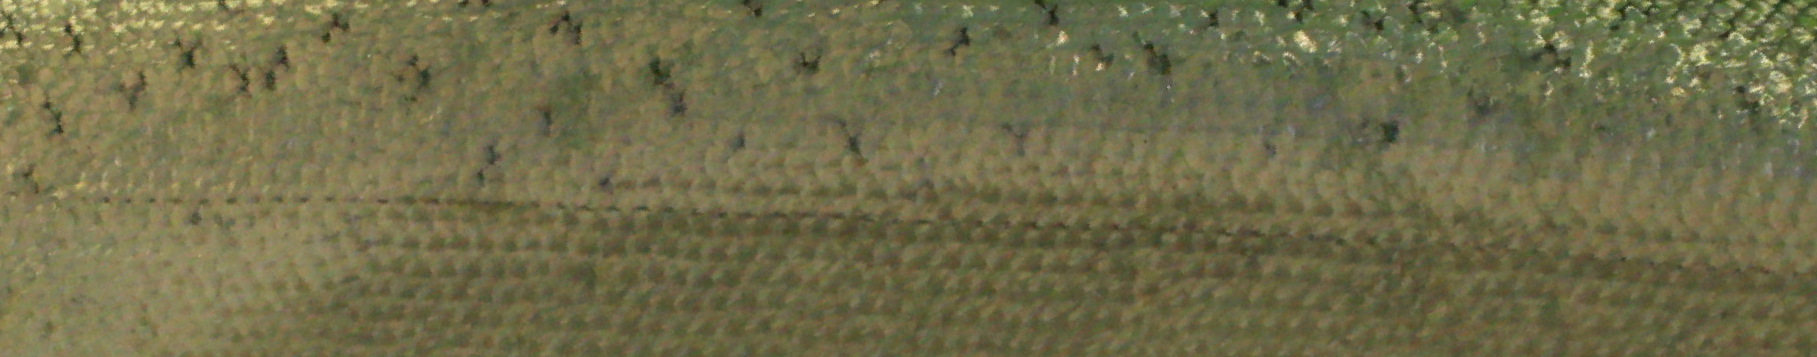

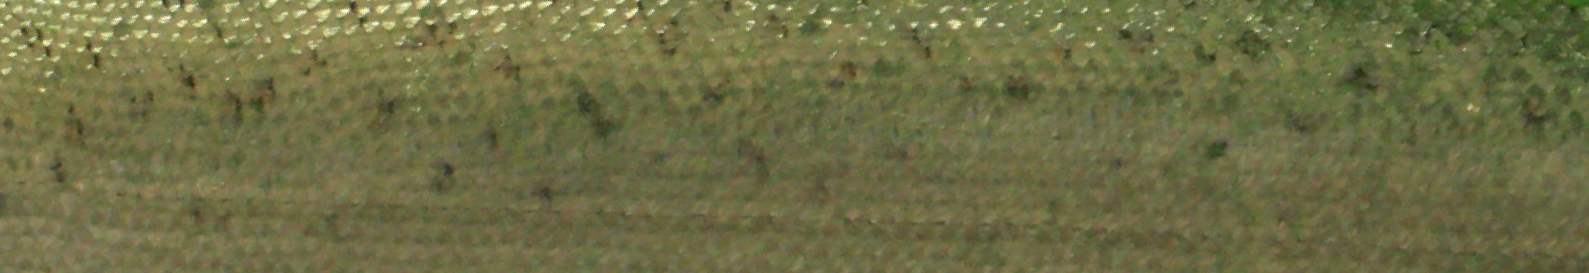

In [13]:
oneexample = list(data_dir.glob('FCF1EF/*'))

for image_path in oneexample[:2]:
    display.display(Image.open(str(image_path)))

## Load using `tf.data`

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [14]:
BATCH_SIZE = 8
IMG_SIZE=160
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [15]:
for f in list_ds.take(5):
  print(f.numpy())

b'/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1/915E5A/fish_2_915E5A_01.png'
b'/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1/8BFAE5/fish_2_8BFAE5__03.png'
b'/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1/024/fish_2_024_11.png'
b'/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1/8BFAE5/fish_2_8BFAE5__1.png'
b'/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_MERGE/SESSION1/108/fish_2_108_02.png'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [16]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [17]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = (img/127.5) - 1
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [18]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #img = Image.open(file_path)
  #img = image.load_img(file_path)
  #img = img.convert('RGB')
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [20]:
#for image, label in labeled_ds.take(1):
#  print("Image shape: ", image.numpy().shape)
#  print("Label: ", label.numpy())

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [21]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [22]:
def prepare_for_testing(ds, cache=False):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [24]:
train_ds = prepare_for_training(labeled_ds)
#test_ds = prepare_for_training(labeled_ds_test)

#image_batch, label_batch = next(iter(train_ds))

In [25]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [26]:
#show_batch(image_batch.numpy(), label_batch.numpy())

### split dataset

In [27]:
train_size = int(0.7 * image_count)
val_size = int(0.15 * image_count)
test_size = int(0.15 * image_count)

full_dataset = train_ds.shuffle(buffer_size=1000,reshuffle_each_iteration = False )
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)
test_dataset2 = test_ds.take(test_size)

NameError: name 'test_ds' is not defined

In [28]:
#image_batch, label_batch = next(iter(train_dataset))
#show_batch(image_batch.numpy(), label_batch.numpy())

In [31]:
train_batches = train_dataset.batch(BATCH_SIZE)
validation_batches = val_dataset.batch(BATCH_SIZE)
test_batches = val_dataset.batch(BATCH_SIZE)

Now shuffle and batch the data.

In [32]:
n=0
for image_batch, label_batch in train_dataset.take(1):
   n=+1
   pass
print(n)
image_batch.shape

1


TensorShape([8, 160, 160, 3])

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like `jackfruit` and `syringe`, but this base of knowledge will help us tell apart cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. Obviously, the very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to instead depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck features retain much generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image to a `5x5x1280` block of features. See what it does to the example batch of images:

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting `layer.trainable = False`), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to `False` will freeze all the layers.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = keras.layers.Dense(len(CLASS_NAMES), activation=K.relu)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [ ]:
from losses import *

#loss_layer =Loss=LSoftmaxLinear(len(CLASS_NAMES),1280,3)
#LSoftmaxLinear(len(CLASS_NAMES), 1280, 3)
loss_layer=OriginalSoftmaxLinear(len(CLASS_NAMES))
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
model.summary()

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

### Train the model

After training for 10 epochs, you should see ~96% accuracy.

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [ ]:
num_train, num_val, num_test = (train_size, val_size, test_size)


In [ ]:
initial_epochs = 100
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(val_dataset, steps = validation_steps)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
#image_batch, label_batch = next(iter(train_dataset))
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,validation_steps=validation_steps)

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Compile the model

Compile the model using a much lower training rate.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['categorical_accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

### Continue Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [ ]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=val_dataset,validation_steps=validation_steps)

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


## Test dataset

In [ ]:
# You can also evaluate or predict on a dataset.
print('\n# Evaluate')
model.evaluate(test_dataset)

## Save model

In [ ]:
# Save the model
model.save('mobilenetfish.h5')

In [ ]:
for x,y in test_dataset2.take(1):
    predictions = model.predict(x)
    #print(predictions[0])
    #print('predictions shape:', predictions.shape)
    print('x shape:', x.shape)
    for n in range(8):
        indxmax=np.argmax(predictions[n])
        print('predictions max index:',indxmax)
        print('predictions:', CLASS_NAMES[indxmax] )
        print('real:', CLASS_NAMES[np.argwhere(y[n]).ravel()] )
       

Single image?

In [ ]:
image_batch, label_batch = next(iter(labeled_ds_test))

In [ ]:
predictions = model.predict(test_dataset2)

In [ ]:
loss0,accuracy0 = model.evaluate(test_dataset2, steps = validation_steps)